<h1 style="text-align: center;"> Model Tuning </p>

<a id='Table-of-Contents'></a>


##  Table of Contents
1. [Required Libraries](#Required-Libraries)
2. [Load Data](#Load-Data)
3. 

## Required Libraries

[[ go back to the top ]](#Table-of-contents)

This notebook uses several Python libraries such as:

In [260]:
# Load required packages 
import datetime
from datetime import timedelta
import numpy as np
import pandas as pd
import os

# Visuals
import matplotlib.pyplot as plt
import seaborn as sns

# Time-Series
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARMA, ARIMA

from sklearn.model_selection import train_test_split  

from scipy import signal
import scipy.stats as stats

from Functions import LOAD_DATA

import warnings
warnings.filterwarnings("ignore")

<a id='Load-Data'></a>

---
## Load Data

[[ go back to the top ]](#Table-of-Contents)

# Load Data Function
def LOAD_DATA(filepath, filename):
    # Read CSV files
    if filename.endswith('.csv'):
        new_df = pd.read_csv(filepath+filename)

    # Read Excel files
    elif filename.endswith('.xlsx'):
        new_df = pd.read_excel(filepath+filename)
    print(type(new_df.index))
    if type(new_df.index) != pd.core.indexes.datetimes.DatetimeIndex:
        for col in new_df.columns:
            if col.lower().find('date') != -1:
                print(f"TIMESTAMP FOUND! '{col}'")
                print()
                new_df['date'] = pd.to_datetime(new_df[col]) # format = '%Y/%m/%d'
                new_df.set_index('date', inplace = True)
                # If datetime col was already == 'date', no need to drop col after set_index, otherwise...
                if col != 'date':
                    new_df.drop(columns = col, inplace = True)
                
    # Try to identify the date column
    elif type(new_df.index) == pd.core.indexes.datetimes.DatetimeIndex:
        print('Index already in datetime')
        
    display(new_df.info())
    return new_df

In [261]:
#
fname = 'closing10_holiweekend_nans.csv'
stocks = pd.read_csv(r'../EDA-Brandon/'+fname,
                     index_col = 0,
                     parse_dates=True,
                     infer_datetime_format=True,
                     keep_date_col=True)

fname = 'top3_sentiment_imputed0_rolled5d.csv'
sents = pd.read_csv(r'../EDA-Brandon/'+fname,
                    index_col = 0,
                    parse_dates=True,
                    infer_datetime_format=True,
                    keep_date_col=True)

fname = 'crude_futures_ARIMA.csv'
comms = pd.read_csv(r'../../data/Financial_Market/'+fname,
                    index_col = 0,
                    parse_dates=True,
                    infer_datetime_format=True,
                    keep_date_col=True)

In [262]:
display(len(sents))
display(sents.isnull().sum().sum())
sents.isnull().sum()
#sents.head()

1479

903

d_f_pipeline                 832
d_g_oil                        8
i_g_airline                   33
d_f_pipeline_imputed           0
d_g_oil_imputed                0
i_g_airline_imputed            0
d_f_pipeline_roll5d            4
d_g_oil_roll5d                 4
i_g_airline_roll5d             4
d_f_pipeline_imputed_lagg      1
d_g_oil_imputed_lagg           1
i_g_airline_imputed_lagg       1
d_f_pipeline_roll5d_lagg       5
d_g_oil_roll5d_lagg            5
i_g_airline_roll5d_lagg        5
dtype: int64

In [263]:
display(len(stocks))
display(stocks.isnull().sum().sum())
stocks.isnull().sum()
#stocks.head()

1478

9010

bp_plc                                    450
chevron_corporation                       450
conocophillips                            450
exxon_mobil_corporation                   450
marathon_oil_corporation                  450
marathon_petroleum_corporation            450
occidental_petroleum_corporation          450
phillips_66                               450
pioneer_natural_resources_company         450
valero_energy_corporation                 450
bp_plc_lagg                               451
chevron_corporation_lagg                  451
conocophillips_lagg                       451
exxon_mobil_corporation_lagg              451
marathon_oil_corporation_lagg             451
marathon_petroleum_corporation_lagg       451
occidental_petroleum_corporation_lagg     451
phillips_66_lagg                          451
pioneer_natural_resources_company_lagg    451
valero_energy_corporation_lagg            451
dtype: int64

In [264]:
display(len(comms))
display(comms.isnull().sum().sum())
comms.isnull().sum()
#stocks.head()

1479

2326

futures_settle                 460
futures_open_interest          460
nymex_crude_per_barrel         473
futures_settle_lagg            460
nymex_crude_per_barrel_lagg    473
dtype: int64

In [265]:
# Join all the others
df = stocks.join(sents, how = 'left', rsuffix=f'_{fname[:-4]}')
df = df.join(comms, how = 'left', )
display(df.isnull().sum().sum())

12234

In [266]:
df

,bp_plc,chevron_corporation,conocophillips,exxon_mobil_corporation,marathon_oil_corporation,marathon_petroleum_corporation,occidental_petroleum_corporation,phillips_66,pioneer_natural_resources_company,valero_energy_corporation,...,d_g_oil_imputed_lagg,i_g_airline_imputed_lagg,d_f_pipeline_roll5d_lagg,d_g_oil_roll5d_lagg,i_g_airline_roll5d_lagg,futures_settle,futures_open_interest,nymex_crude_per_barrel,futures_settle_lagg,nymex_crude_per_barrel_lagg
2017-03-01,113.88,113.88,49.05,83.02,16.45,50.99,66.24,79.37,193.52,68.48,...,NaN,NaN,NaN,NaN,NaN,53.83,456844.0,53.82,NaN,NaN
2017-03-02,113.36,113.36,48.21,83.30,16.14,51.04,65.50,78.33,191.17,66.45,...,-0.209091,-0.500000,NaN,NaN,NaN,52.61,444178.0,52.63,53.83,53.82
2017-03-03,113.55,113.55,47.82,82.46,16.18,51.27,64.86,78.34,194.18,66.08,...,-0.133333,-0.033333,NaN,NaN,NaN,53.33,457323.0,53.33,52.61,52.63
2017-03-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.075000,-0.220000,NaN,NaN,NaN,NaN,NaN,NaN,53.33,53.33
2017-03-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.066667,-0.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.134667,-0.210294,-4.666667e-02,-0.219851,-0.221432,NaN,NaN,NaN,65.61,NaN
2021-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.258824,-0.226667,3.333333e-02,-0.232401,-0.209843,NaN,NaN,NaN,NaN,NaN
2021-03-15,110.25,110.25,58.16,60.39,12.05,57.86,29.30,87.84,165.76,81.83,...,-0.051613,-0.372727,-3.000000e-02,-0.190912,-0.251588,65.39,168790.0,NaN,NaN,NaN
2021-03-16,107.64,107.64,56.58,59.11,11.46,56.21,28.17,84.93,163.03,79.32,...,-0.147826,-0.126316,-1.291434e-09,-0.168898,-0.224928,64.80,134277.0,NaN,65.39,NaN


In [267]:
# To use ARIMA we must have evenly spaced data which means we must impute data
df.fillna(method='ffill', inplace =True)
display(df.isnull().sum().sum())
display(df.head())

42

,bp_plc,chevron_corporation,conocophillips,exxon_mobil_corporation,marathon_oil_corporation,marathon_petroleum_corporation,occidental_petroleum_corporation,phillips_66,pioneer_natural_resources_company,valero_energy_corporation,...,d_g_oil_imputed_lagg,i_g_airline_imputed_lagg,d_f_pipeline_roll5d_lagg,d_g_oil_roll5d_lagg,i_g_airline_roll5d_lagg,futures_settle,futures_open_interest,nymex_crude_per_barrel,futures_settle_lagg,nymex_crude_per_barrel_lagg
2017-03-01,113.88,113.88,49.05,83.02,16.45,50.99,66.24,79.37,193.52,68.48,...,NaN,NaN,NaN,NaN,NaN,53.83,456844.0,53.82,NaN,NaN
2017-03-02,113.36,113.36,48.21,83.30,16.14,51.04,65.50,78.33,191.17,66.45,...,-0.209091,-0.500000,NaN,NaN,NaN,52.61,444178.0,52.63,53.83,53.82
2017-03-03,113.55,113.55,47.82,82.46,16.18,51.27,64.86,78.34,194.18,66.08,...,-0.133333,-0.033333,NaN,NaN,NaN,53.33,457323.0,53.33,52.61,52.63
2017-03-04,113.55,113.55,47.82,82.46,16.18,51.27,64.86,78.34,194.18,66.08,...,0.075000,-0.220000,NaN,NaN,NaN,53.33,457323.0,53.33,53.33,53.33
2017-03-05,113.55,113.55,47.82,82.46,16.18,51.27,64.86,78.34,194.18,66.08,...,-0.066667,-0.200000,NaN,NaN,NaN,53.33,457323.0,53.33,53.33,53.33


In [268]:
df.isnull().sum()

bp_plc                                    0
chevron_corporation                       0
conocophillips                            0
exxon_mobil_corporation                   0
marathon_oil_corporation                  0
marathon_petroleum_corporation            0
occidental_petroleum_corporation          0
phillips_66                               0
pioneer_natural_resources_company         0
valero_energy_corporation                 0
bp_plc_lagg                               1
chevron_corporation_lagg                  1
conocophillips_lagg                       1
exxon_mobil_corporation_lagg              1
marathon_oil_corporation_lagg             1
marathon_petroleum_corporation_lagg       1
occidental_petroleum_corporation_lagg     1
phillips_66_lagg                          1
pioneer_natural_resources_company_lagg    1
valero_energy_corporation_lagg            1
d_f_pipeline                              0
d_g_oil                                   0
i_g_airline                     

In [269]:
# Sub-sample to well-defined window
df_sub = df[pd.to_datetime('2017-03-08'):pd.to_datetime('2021-03-05')].copy()
df_sub.head()

,bp_plc,chevron_corporation,conocophillips,exxon_mobil_corporation,marathon_oil_corporation,marathon_petroleum_corporation,occidental_petroleum_corporation,phillips_66,pioneer_natural_resources_company,valero_energy_corporation,...,d_g_oil_imputed_lagg,i_g_airline_imputed_lagg,d_f_pipeline_roll5d_lagg,d_g_oil_roll5d_lagg,i_g_airline_roll5d_lagg,futures_settle,futures_open_interest,nymex_crude_per_barrel,futures_settle_lagg,nymex_crude_per_barrel_lagg
2017-03-08,109.61,109.61,45.91,81.03,14.87,50.22,62.06,77.25,184.25,66.87,...,-0.333333,-0.300000,-0.18,-0.125000,-0.242000,50.28,400322.0,49.83,53.14,52.68
2017-03-09,110.04,110.04,46.48,81.67,16.07,49.28,62.50,76.84,187.75,66.48,...,-0.216667,-0.066667,-0.18,-0.183333,-0.211333,49.28,365391.0,48.75,50.28,49.83
2017-03-10,110.61,110.61,45.67,81.61,16.16,49.87,62.60,78.86,184.72,66.57,...,-0.300000,-0.457143,-0.12,-0.230000,-0.262762,48.49,331486.0,48.05,49.28,48.75
2017-03-11,110.61,110.61,45.67,81.61,16.16,49.87,62.60,78.86,184.72,66.57,...,-0.150000,-0.140000,-0.24,-0.190000,-0.240762,48.49,331486.0,48.05,48.49,48.05
2017-03-12,110.61,110.61,45.67,81.61,16.16,49.87,62.60,78.86,184.72,66.57,...,-0.350000,-0.200000,-0.18,-0.270000,-0.232762,48.49,331486.0,48.05,48.49,48.05


In [270]:
df_sub.isnull().sum().sum()

0

In [271]:
df_weekdays = df_sub[df_sub.index.dayofweek < 5].copy()
df_weekdays.head()

,bp_plc,chevron_corporation,conocophillips,exxon_mobil_corporation,marathon_oil_corporation,marathon_petroleum_corporation,occidental_petroleum_corporation,phillips_66,pioneer_natural_resources_company,valero_energy_corporation,...,d_g_oil_imputed_lagg,i_g_airline_imputed_lagg,d_f_pipeline_roll5d_lagg,d_g_oil_roll5d_lagg,i_g_airline_roll5d_lagg,futures_settle,futures_open_interest,nymex_crude_per_barrel,futures_settle_lagg,nymex_crude_per_barrel_lagg
2017-03-08,109.61,109.61,45.91,81.03,14.87,50.22,62.06,77.25,184.25,66.87,...,-0.333333,-0.300000,-0.18,-0.125000,-0.242000,50.28,400322.0,49.83,53.14,52.68
2017-03-09,110.04,110.04,46.48,81.67,16.07,49.28,62.50,76.84,187.75,66.48,...,-0.216667,-0.066667,-0.18,-0.183333,-0.211333,49.28,365391.0,48.75,50.28,49.83
2017-03-10,110.61,110.61,45.67,81.61,16.16,49.87,62.60,78.86,184.72,66.57,...,-0.300000,-0.457143,-0.12,-0.230000,-0.262762,48.49,331486.0,48.05,49.28,48.75
2017-03-13,109.35,109.35,45.84,81.42,15.84,50.99,62.88,79.01,184.41,67.66,...,-0.083333,-0.500000,-0.12,-0.220000,-0.272762,48.40,288689.0,47.95,48.49,48.05
2017-03-14,107.36,107.36,44.94,80.99,15.32,50.01,63.04,78.51,179.31,67.44,...,-0.050000,-0.300000,-0.12,-0.186667,-0.319429,47.72,264173.0,47.24,48.40,47.95


In [272]:
list(df_weekdays.columns)

['bp_plc',
 'chevron_corporation',
 'conocophillips',
 'exxon_mobil_corporation',
 'marathon_oil_corporation',
 'marathon_petroleum_corporation',
 'occidental_petroleum_corporation',
 'phillips_66',
 'pioneer_natural_resources_company',
 'valero_energy_corporation',
 'bp_plc_lagg',
 'chevron_corporation_lagg',
 'conocophillips_lagg',
 'exxon_mobil_corporation_lagg',
 'marathon_oil_corporation_lagg',
 'marathon_petroleum_corporation_lagg',
 'occidental_petroleum_corporation_lagg',
 'phillips_66_lagg',
 'pioneer_natural_resources_company_lagg',
 'valero_energy_corporation_lagg',
 'd_f_pipeline',
 'd_g_oil',
 'i_g_airline',
 'd_f_pipeline_imputed',
 'd_g_oil_imputed',
 'i_g_airline_imputed',
 'd_f_pipeline_roll5d',
 'd_g_oil_roll5d',
 'i_g_airline_roll5d',
 'd_f_pipeline_imputed_lagg',
 'd_g_oil_imputed_lagg',
 'i_g_airline_imputed_lagg',
 'd_f_pipeline_roll5d_lagg',
 'd_g_oil_roll5d_lagg',
 'i_g_airline_roll5d_lagg',
 'futures_settle',
 'futures_open_interest',
 'nymex_crude_per_barrel',

### Fit an ARIMA Model

In [273]:
# Set-Up Target-Variables: NYSE Closing Price
targets = ['bp_plc',
           'chevron_corporation',
           'conocophillips',
           'exxon_mobil_corporation',
           'marathon_oil_corporation',
           'marathon_petroleum_corporation',
           'occidental_petroleum_corporation',
           'phillips_66',
           'pioneer_natural_resources_company',
           'valero_energy_corporation']

# DataFrame of 10 large Oil Companies
target_df = df_weekdays[targets]

In [274]:
# Check that all is copacetic
target_df

,bp_plc,chevron_corporation,conocophillips,exxon_mobil_corporation,marathon_oil_corporation,marathon_petroleum_corporation,occidental_petroleum_corporation,phillips_66,pioneer_natural_resources_company,valero_energy_corporation
2017-03-08,109.61,109.61,45.91,81.03,14.87,50.22,62.06,77.25,184.25,66.87
2017-03-09,110.04,110.04,46.48,81.67,16.07,49.28,62.50,76.84,187.75,66.48
2017-03-10,110.61,110.61,45.67,81.61,16.16,49.87,62.60,78.86,184.72,66.57
2017-03-13,109.35,109.35,45.84,81.42,15.84,50.99,62.88,79.01,184.41,67.66
2017-03-14,107.36,107.36,44.94,80.99,15.32,50.01,63.04,78.51,179.31,67.44
...,...,...,...,...,...,...,...,...,...,...
2021-03-01,102.05,102.05,52.61,56.40,11.20,56.10,27.64,84.70,148.47,77.80
2021-03-02,102.44,102.44,52.28,56.07,11.23,56.03,27.82,82.27,149.75,76.63
2021-03-03,103.59,103.59,53.66,56.52,11.63,56.07,28.66,83.84,154.16,77.53
2021-03-04,104.50,104.50,55.62,58.71,12.36,56.51,29.90,84.41,158.57,76.37


### ARIMA trouble predicting with all the features

In [275]:
# # Create Train/Test-Split
# # Typical: test_size = most recent 20%(small datasets) - 33%(large datasets)
# X_train, X_valid, y_train, y_valid = train_test_split(df.drop(columns = targets),  
#                                                     df['phillips_66'],  
#                                                     test_size = 0.2, 
#                                                     shuffle = False) 

### Try fewer features

In [276]:
list(df_weekdays.columns)

['bp_plc',
 'chevron_corporation',
 'conocophillips',
 'exxon_mobil_corporation',
 'marathon_oil_corporation',
 'marathon_petroleum_corporation',
 'occidental_petroleum_corporation',
 'phillips_66',
 'pioneer_natural_resources_company',
 'valero_energy_corporation',
 'bp_plc_lagg',
 'chevron_corporation_lagg',
 'conocophillips_lagg',
 'exxon_mobil_corporation_lagg',
 'marathon_oil_corporation_lagg',
 'marathon_petroleum_corporation_lagg',
 'occidental_petroleum_corporation_lagg',
 'phillips_66_lagg',
 'pioneer_natural_resources_company_lagg',
 'valero_energy_corporation_lagg',
 'd_f_pipeline',
 'd_g_oil',
 'i_g_airline',
 'd_f_pipeline_imputed',
 'd_g_oil_imputed',
 'i_g_airline_imputed',
 'd_f_pipeline_roll5d',
 'd_g_oil_roll5d',
 'i_g_airline_roll5d',
 'd_f_pipeline_imputed_lagg',
 'd_g_oil_imputed_lagg',
 'i_g_airline_imputed_lagg',
 'd_f_pipeline_roll5d_lagg',
 'd_g_oil_roll5d_lagg',
 'i_g_airline_roll5d_lagg',
 'futures_settle',
 'futures_open_interest',
 'nymex_crude_per_barrel',

In [293]:
# Create Train/Test-Split
feature_list = ['i_g_airline_roll5d_lagg',
                'd_g_oil_roll5d_lagg',
                'd_f_pipeline_roll5d_lagg',
                'bp_plc_lagg',
                'chevron_corporation_lagg',
                'conocophillips_lagg',
                'exxon_mobil_corporation_lagg',
                'marathon_oil_corporation_lagg',
                'marathon_petroleum_corporation_lagg',
                'occidental_petroleum_corporation_lagg',
                'phillips_66_lagg',
                'pioneer_natural_resources_company_lagg',
                'valero_energy_corporation_lagg',
                'futures_open_interest',
                'futures_settle_lagg',
                'nymex_crude_per_barrel_lagg']

# Pick your target
target = 'exxon_mobil_corporation'
# Typical: test_size = most recent 20%(small datasets) - 33%(large datasets)
X_train, X_valid, y_train, y_valid = train_test_split(df_weekdays[feature_list],  
                                                    df_weekdays[target],  
                                                    test_size = 0.2, 
                                                    shuffle = False) 

In [294]:
# Check shape and verify proper split above 
print(X_train.shape) 
print(X_valid.shape)  
print(y_train.shape) 
print(y_valid.shape)

(834, 16)
(209, 16)
(834,)
(209,)


In [295]:
# Before fitting a model in statsmodels (Hint: Add the intercept)  
X_train = sm.add_constant(X_train) 
X_valid = sm.add_constant(X_valid)
# Check that all is copacetic  
X_train.head()

,const,i_g_airline_roll5d_lagg,d_g_oil_roll5d_lagg,d_f_pipeline_roll5d_lagg,bp_plc_lagg,chevron_corporation_lagg,conocophillips_lagg,exxon_mobil_corporation_lagg,marathon_oil_corporation_lagg,marathon_petroleum_corporation_lagg,occidental_petroleum_corporation_lagg,phillips_66_lagg,pioneer_natural_resources_company_lagg,valero_energy_corporation_lagg,futures_open_interest,futures_settle_lagg,nymex_crude_per_barrel_lagg
2017-03-08,1.0,-0.242000,-0.125000,-0.18,111.81,111.81,47.72,82.52,16.28,50.15,64.70,77.48,193.94,65.62,400322.0,53.14,52.68
2017-03-09,1.0,-0.211333,-0.183333,-0.18,109.61,109.61,45.91,81.03,14.87,50.22,62.06,77.25,184.25,66.87,365391.0,50.28,49.83
2017-03-10,1.0,-0.262762,-0.230000,-0.12,110.04,110.04,46.48,81.67,16.07,49.28,62.50,76.84,187.75,66.48,331486.0,49.28,48.75
2017-03-13,1.0,-0.272762,-0.220000,-0.12,110.61,110.61,45.67,81.61,16.16,49.87,62.60,78.86,184.72,66.57,288689.0,48.49,48.05
2017-03-14,1.0,-0.319429,-0.186667,-0.12,109.35,109.35,45.84,81.42,15.84,50.99,62.88,79.01,184.41,67.66,264173.0,48.40,47.95


In [296]:
# statsmodels can't handle missing values
X_train.isnull().sum().sum(), X_valid.isnull().sum().sum(), y_train.isnull().sum().sum(), y_valid.isnull().sum().sum()

(0, 0, 0, 0)

In [297]:
# Starting AIC, p, and q.
best_aic = 99 * (10 ** 16) # Just a really big number
best_p = 0
best_q = 0
d=0
# Use nested for loop to iterate over values of p and q.
for p in range(5):
    for q in range(5):
        # Insert try and except statements.
        try:
            # Fitting an ARIMA(p, 1, q) model.
            print(f'Attempting to fit ARIMA({p},{d},{q})') # Default d=1 is given
            
            # Instantiate ARIMA model
            arima = ARIMA(endog = y_train.astype(float).dropna(), # endog = Y variable ,"enogenous param"
                          order = (p,d,q)) # values of p, d, q
            
            # Fit ARIMA model.
            model = arima.fit()

            # Print out AIC for ARIMA(p, 1, q) model.
            print(f'The AIC for ARIMA({p},{d},{q}) is: {model.aic}')

            # Is my current model's AIC better than our best_aic?
            if model.aic < best_aic: # Update best params if new and improved score
                
                # If so, let's overwrite best_aic, best_p, and best_q.
                best_aic = model.aic
                best_p = p
                best_q = q

        except:
            pass
print()
print()
print('MODEL FINISHED!')
print(f'Our model that minimizes AIC on the training data is the ARIMA({best_p},1,{best_q}).')
print(f'This model has an AIC of {best_aic}.')

Attempting to fit ARIMA(0,0,0)
The AIC for ARIMA(0,0,0) is: 6323.656121371801
Attempting to fit ARIMA(0,0,1)
The AIC for ARIMA(0,0,1) is: 5256.397576045078
Attempting to fit ARIMA(0,0,2)
Attempting to fit ARIMA(0,0,3)
Attempting to fit ARIMA(0,0,4)
Attempting to fit ARIMA(1,0,0)
The AIC for ARIMA(1,0,0) is: 2442.3204354081536
Attempting to fit ARIMA(1,0,1)
The AIC for ARIMA(1,0,1) is: 2444.1234275411
Attempting to fit ARIMA(1,0,2)
The AIC for ARIMA(1,0,2) is: 2443.3517999804985
Attempting to fit ARIMA(1,0,3)
The AIC for ARIMA(1,0,3) is: 2427.963994565465
Attempting to fit ARIMA(1,0,4)
The AIC for ARIMA(1,0,4) is: 2429.533488287349
Attempting to fit ARIMA(2,0,0)
The AIC for ARIMA(2,0,0) is: 2444.1445020000083
Attempting to fit ARIMA(2,0,1)
The AIC for ARIMA(2,0,1) is: 2437.2048984305416
Attempting to fit ARIMA(2,0,2)
The AIC for ARIMA(2,0,2) is: 2437.41128927303
Attempting to fit ARIMA(2,0,3)
The AIC for ARIMA(2,0,3) is: 2429.7207743497916
Attempting to fit ARIMA(2,0,4)
Attempting to fi

---

In [302]:
# AnchoredArtists
# Offset Box: Modified from...
# https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html
def draw_text(ax, p,d,q):
    from matplotlib.offsetbox import AnchoredText
    at = AnchoredText(f'ARIMA ({p}, {d}, {q}) \n\nAIC: {best_aic:.1f}',
                      loc=1, prop=dict(size=10), frameon=True,
                      )
    at.patch.set_boxstyle("round,pad=0., rounding_size=0.2")
    ax.add_artist(at)

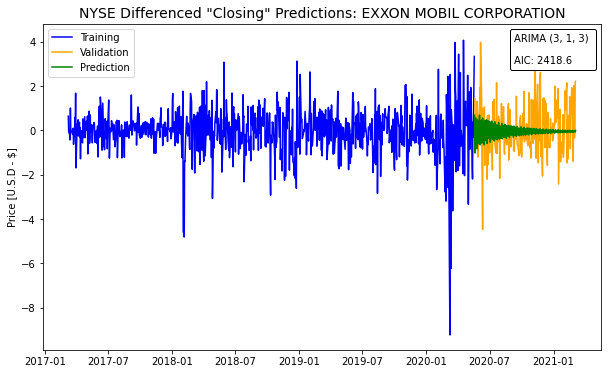

In [303]:
# MODEL FINISHED!
# Our model that minimizes AIC on the training data is the ARIMA(0,1,0).
# This model has an AIC of 951.67
p = 3; d = 1; q = 3

# Instantiate best model found by GridSearch above
model = ARIMA(#endog = np.array(y_train),  # endog = endogenous "Target" Variable
              endog = y_train.astype(float).dropna(),
              #dates = y_train.index, # pass in training index using the ARIMA dates parameter
              #freq = 'B',
              order = (p,d,q))

# Fit ARIMA model.
arima = model.fit()
# Generate predictions based on valid set.
start_valid = y_valid.index[0]
end_valid = y_valid.index[-1]
#print(start_valid, type(start_valid))
#print(end_valid, type(end_valid))
preds = model.predict(params = arima.params,
                      start = start_valid,
                      end = end_valid)

# Plot data.
#plt.figure(figsize=(10,8))
fig, axs = plt.subplots(nrows = 1,
                        ncols = 1,
                        figsize = (10, 6));

# Plot training data.
#plt.plot(y_train.index, pd.DataFrame(y_train), color = 'blue')
axs.plot(y_train.index, pd.DataFrame(y_train).diff(), color = 'blue', label = 'Training')
# Plot validing data.
#plt.plot(y_valid.index, pd.DataFrame(y_valid), color = 'orange')
axs.plot(y_valid.index, pd.DataFrame(y_valid).diff(), color = 'orange', label='Validation')
# Plot predicted valid values.
axs.plot(y_valid.index, preds, color = 'green', label = 'Prediction')
#axs.set_xlabel(f'Motor-1 Target [mm]')
axs.set_ylabel(f'Price [U.S.D - $]')
draw_text(axs, p,d,q)
title_co = target.replace('_' , ' ').upper()
plt.title(label = f'NYSE Differenced "Closing" Predictions: {title_co}', fontsize=14);
plt.legend(loc='lower_right');

### fig, ax = plt.subplots(figsize=(12,6))
g  = res.plot_predict(start=start_valid, end= end_valid,ax=ax)

#### > *Insights*
>
>

In [ ]:
print(arima.summary())

In [ ]:
fig, ax = plt.subplots(nrows = 3,
                       ncols = 1,
                       figsize=(20,10), 
                       sharex = True)

df_sub = df[['workplaces']]

# Element-wise subtraction w/ a Series, for set_title("RSS")
df_diff = df_differenced.workplaces

fsize = 15
p = 5; d = 1; q = 1

for nax in range(3):
    if nax == 0:
        # Instantiate the AR Model, choose "p" (p, d = 1, q = 0)
        model = ARIMA(df_sub, order=(p,d,0))
        # Fit the AR Model
        preds_AR = model.fit(disp=-1)
        ax[nax].plot(preds_AR.fittedvalues, label = f'AR({p}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'AR({p}) Model - RSS: %.4f'%sum((preds_AR.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 1:
        # MA Model, choose "q" (p = 0, d = 1, q)
        model = ARIMA(df_sub, order=(0,d,q))
        preds_MA = model.fit(disp=-1)
        ax[nax].plot(preds_MA.fittedvalues, label = f'MA({q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'MA({q}) Model - RSS: %.4f'%sum((preds_MA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    elif nax == 2:
        # ARIMA model, choose "p" & "q" (p, d, q)
        model = ARIMA(df_sub, order=(p,d,q))
        preds_ARIMA = model.fit(disp=-1)
        ax[nax].plot(preds_ARIMA.fittedvalues, label = f'ARIMA({p},{d},{q}) Predictions')
        # Residual Sum of Squares
        ax[nax].set_title(f'ARIMA({p},{d},{q}) Model - RSS: %.4f'%sum((preds_ARIMA.fittedvalues - df_diff)**2),
                          fontsize = fsize)
        
    ax[nax].plot(df_diff, label = 'Original')    
    ax[nax].legend()
    #ax[nax].set_xlabel('Timestamp')
    ax[nax].set_ylabel('Mobility (% Change)', fontsize = fsize)
    
plt.tight_layout()